# Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor,  VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
from datasets import load_metric
from torchsummary import summary

# Load and prepare data

In [2]:
# Read file names and text labels, and put them in a dataframe
df = pd.read_fwf('IAM-data/IAM-data/iam_lines_gt.txt', header=None)
file_names = df.iloc[::2]
text = df.iloc[1::2]
del df
file_names.columns = ['file_name']
text.columns = ['text']
file_names.reset_index(drop=True, inplace=True)
text.reset_index(drop=True, inplace=True)

data = pd.concat([file_names, text], axis=1)
data.head()


,file_name,text
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country


In [3]:
# Check longest amount of text
data['text'].apply(len).max()

54

In [4]:
# split train and validation data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=0)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [5]:
# Create regular Pytorch dataset to load images and process them during training

class Task3IAM(Dataset):
    def __init__(self, img_dir, data, processor, max_target_length = 64):
        self.img_dir = img_dir
        self.data = data
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.data['file_name'][idx]
        text = self.data['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(os.path.join(self.img_dir, file_name)).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = Task3IAM(img_dir='IAM-data/IAM-data/img/', data = train_data, processor = processor)
eval_dataset = Task3IAM(img_dir='IAM-data/IAM-data/img/', data = val_data, processor=processor)

In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 5966
Number of validation examples: 1492


In [8]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v)

pixel_values tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
labels tensor([   0,  756,    7,   32, 2490,  168,   33,   18,  136,   59, 1229,    5,
         662,  333,   10, 3034,    2, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -1

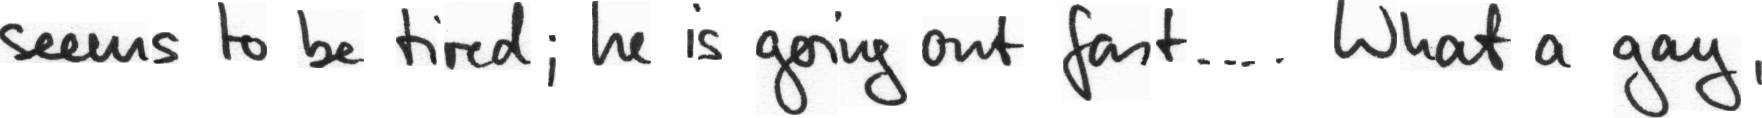

In [9]:
image = Image.open(train_dataset.img_dir + train_data['file_name'][0]).convert("RGB")
image

In [10]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

seems to be tired; he is going out fast.... What a gay


# Fine tune model

In [11]:
# Import pretrained model
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

# Change settings for pretrained model
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters of model for generating text
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Count parameters in model
sum([param.nelement() for param in model.parameters()])

61596672

In [16]:
# set training parameters
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    num_train_epochs = 2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    gradient_accumulation_steps = 1,
    predict_with_generate=True,
    fp16=False, 
)

In [17]:
# create function to calculate cer between label text and generated text, to compute metrics
cer_metric = load_metric("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [18]:
# initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)


In [19]:
# finetine the pretrained model
trainer.train()

C:\Users\jelme\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5966
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1492
  0%|          | 2/1492 [00:28<5:49:35, 14.08s/it]

{'loss': 9.0997, 'learning_rate': 4.993297587131368e-05, 'epoch': 0.0}


  0%|          | 4/1492 [00:52<5:15:57, 12.74s/it]

{'loss': 7.9208, 'learning_rate': 4.986595174262735e-05, 'epoch': 0.01}


KeyboardInterrupt: 